
## Modules


In [1]:
# Libraries
import pandas as pd
import missingno  as msno

## Data

### Description of data

Reviews Dataset:

- id - numerical index, the unique observation index for the given dataset
- rating (training set only) - categorical, business satisfaction rating: 1, 2, 3, 4, 5 (1: worse, 5: best)
- text - string, the review text itself
- business_id - string, unique business identifier
- user_id - string, unique customer identifier
- useful - integer, number of useful votes received
- funny - integer, number of funny votes received
- cool - integer, number of cool votes received
- date - string, date formatted YYYY-MM-DD

Businesses Dataset:

- business_id - string, unique business identifier
- name - string, the business's name
- address - string, the full address of the business
- city - string, the city
- state - string, 2 character state code, if applicable
- postal_code - string, the postal code
- latitude - float, latitude
- longitude - float, longitude
- attributes - object, business attributes to values. note: some attribute values might be objects
- categories - an array of strings of business categories
- hours - an object of key day to value hours, hours are using a 24hr clock

Customers Dataset:

- user_id - string, unique customer identifier
- name - string, the customer's first name
- ser_since - string, when the customer started rating businesses YYYY-MM-DD
- useful - integer, number of useful votes sent by the customer
- funny - integer, number of funny votes sent by the customer
- cool - integer, number of cool votes sent by the customer
- premium_account - array of integers, the years the customer had a premium account thanks to his involvement in writing reviews
- friends - integer, number of friends the customer has on the rating platform
- fans - integer, number of fans the customer has on the rating platform
- compliment_hot - integer, number of hot compliments received by the customer
- compliment_more - integer, number of more compliments received by the customer
- compliment_profile - integer, number of profile compliments received by the customer
- compliment_cute - integer, number of cute compliments received by the customer
- compliment_list - integer, number of list compliments received by the customer
- compliment_note - integer, number of note compliments received by the customer
- compliment_plain - integer, number of plain compliments received by the customer
- compliment_cool - integer, number of cool compliments received by the customer
- compliment_funny - integer, number of funny compliments received by the customer
- compliment_writer - integer, number of writer compliments received by the customer


In [2]:
# Import data
df_business = pd.read_parquet("data/ATML2024_businesses.parquet")

df_Train_reviews = pd.read_parquet("data/ATML2024_reviews_train.parquet")

df_users = pd.read_parquet("data/ATML2024_users.parquet")

In [3]:
# General information on the datasets
# USER DATASET
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 747468 entries, 0 to 747467
Data columns (total 19 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   user_id             747468 non-null  object 
 1   name                747457 non-null  object 
 2   user_since          747468 non-null  object 
 3   useful              747468 non-null  float64
 4   funny               747468 non-null  float64
 5   cool                747468 non-null  float64
 6   premium_account     57420 non-null   object 
 7   friends             747468 non-null  float64
 8   fans                747468 non-null  float64
 9   compliment_hot      747468 non-null  float64
 10  compliment_more     747468 non-null  float64
 11  compliment_profile  747468 non-null  float64
 12  compliment_cute     747468 non-null  float64
 13  compliment_list     747468 non-null  float64
 14  compliment_note     747468 non-null  float64
 15  compliment_plain    747468 non-nul

In [4]:
print(df_Train_reviews.select_dtypes(include=["object", "category"]).columns.tolist())
df_users.head()

['user_id', 'business_id', 'text', 'date']


,user_id,name,user_since,useful,funny,cool,premium_account,friends,fans,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer
0,w7IdXgBVXKjZS5UYDO8cVq,Walker,2007-01-25 16:47:26,7217.0,1259.0,5994.0,2007,14995.0,267.0,250.0,65.0,55.0,56.0,18.0,232.0,844.0,467.0,467.0,239.0
1,gJrXd1wa1EZ2-_UoRgW41j,Daniel,2009-01-25 04:35:42,43091.0,13066.0,27281.0,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2...",4646.0,3138.0,1145.0,264.0,184.0,157.0,251.0,1847.0,7054.0,3131.0,3131.0,1521.0
2,gvz2VtPxToEXh0KFQYXnW2,Steph,2008-07-25 10:41:00,2086.0,1010.0,1003.0,"2009,2010,2011,2012,2013",381.0,52.0,89.0,13.0,10.0,17.0,3.0,66.0,96.0,119.0,119.0,35.0
3,AIdshsLNMm50o7qXSAeDZS,Gwen,2005-11-29 04:38:33,512.0,330.0,299.0,"2009,2010,2011",131.0,28.0,24.0,4.0,1.0,6.0,2.0,12.0,16.0,26.0,26.0,10.0
4,QGFh-RoJ4HscnnE-yMl5Ah,Karen,2007-01-05 19:40:59,29.0,15.0,7.0,None,27.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [5]:
df_users = df_users.apply(lambda x: x.astype(int) if x.dtype == 'float64' else x) # Convert float to int

In [6]:
# REVIEWS DATASET
df_Train_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050000 entries, 0 to 1049999
Data columns (total 9 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   id           1050000 non-null  int64 
 1   user_id      1050000 non-null  object
 2   business_id  1050000 non-null  object
 3   rating       1050000 non-null  int64 
 4   useful       1050000 non-null  int64 
 5   funny        1050000 non-null  int64 
 6   cool         1050000 non-null  int64 
 7   text         1050000 non-null  object
 8   date         1050000 non-null  object
dtypes: int64(5), object(4)
memory usage: 72.1+ MB


In [7]:
# List of categorical variables
print(df_Train_reviews.select_dtypes(include=["object", "category"]).columns.tolist())
df_Train_reviews.head()

['user_id', 'business_id', 'text', 'date']


,id,user_id,business_id,rating,useful,funny,cool,text,date
0,0,gRWsscMiClFGIh2YUjNInT,Ab1ejQzv4eJRLgAlj7tzKT,5,1,0,0,"Sometimes you just want a cup of coffee, in a ...",2013-12-22 23:45:01
1,1,Q3RXWVFtLo4I7MC85ELPh7,QkRhOowLAGVZC5gn4RLkjH,5,1,0,0,Mr. Clyde stopped at our house and asked us if...,2020-02-11 01:00:32
2,2,AD2z6qhmVcRJkywa1KsEFG,ADWVkizi8gKjj07mn8NiMe,4,0,0,0,One of my favorite places to grab a quick bit ...,2014-05-28 19:05:26
3,3,A8HQot2boCpoPIThfHV5iy,wkk30dWY49cSiDU3FKg8FH,5,0,1,0,"Wow, this place is huge! Life size aquarium an...",2014-01-20 23:42:44
4,4,Q7UzjD01YnimUOsvAEQ7JK,wUjnssL0bJIEqdqJs8M0GV,5,0,0,0,I ordered 3 large pizzas and wings for my fam...,2020-01-29 00:20:34


In [8]:
# BUSINESS DATASET
df_business.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138210 entries, 0 to 138209
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   business_id  138210 non-null  object 
 1   name         138210 non-null  object 
 2   address      133772 non-null  object 
 3   city         138210 non-null  object 
 4   state        138210 non-null  object 
 5   postal_code  138145 non-null  object 
 6   latitude     138210 non-null  float64
 7   longitude    138210 non-null  float64
 8   attributes   126589 non-null  object 
 9   categories   138136 non-null  object 
 10  hours        117852 non-null  object 
dtypes: float64(2), object(9)
memory usage: 11.6+ MB


In [9]:
# List of categorical variables
print(df_Train_reviews.select_dtypes(include=["object", "category"]).columns.tolist())
df_business.head()

['user_id', 'business_id', 'text', 'date']


,business_id,name,address,city,state,postal_code,latitude,longitude,attributes,categories,hours
0,wPYArZCy3AETdTjB-x3fpm,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
1,QQNIWVsnAT_iKiKriWrFUt,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
2,wm9eoqjytVbC7dQcM4WSTM,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
3,AfVDXGIKBUE0EdTw_6cMWm,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."
4,QjvanH64QUduo6E-8F33FC,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,"{'BusinessParking': 'None', 'BusinessAcceptsCr...","Burgers, Fast Food, Sandwiches, Food, Ice Crea...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-22:0', '..."


### Merging the datasets

In [10]:
# Assessing columns with the same name
print(
    f"Column(s) name(s) present in user and business: {set(df_users.columns).intersection(set(df_business.columns))}"
)
print(
    f"Column(s) name(s) present in user and reviews: {set(df_users.columns).intersection(set(df_Train_reviews.columns))}"
)
print(
    f"Column(s) name(s) present in business and reviews: {set(df_business.columns).intersection(set(df_Train_reviews.columns))}"
)

Column(s) name(s) present in user and business: {'name'}
Column(s) name(s) present in user and reviews: {'cool', 'funny', 'user_id', 'useful'}
Column(s) name(s) present in business and reviews: {'business_id'}


In [11]:
df_users.rename(
    columns={
        "name": "user_name",
        "useful": "useful_user",
        "funny": "funny_user",
        "cool": "cool_user",
    },
    inplace=True,
)
df_business.rename(columns={"name": "business_name"}, inplace=True)
df_Train_reviews.rename(
    columns={"useful": "useful_review", "funny": "funny_review", "cool": "cool_review"},
    inplace=True,
)

In [12]:
# Assessing the number of obersevations that will be lost if we merge the datasets
print(
    f"Number of user ids not in the reviews dataset: {len(set(df_users.user_id).difference(set(df_Train_reviews.user_id)))}"
)
print(
    f"Number of user ids not in the user dataset: {len(set(df_Train_reviews.user_id).difference(set(df_users.user_id)))}"
)
print(
    f"Number of business ids not in the reviews dataset: {len(set(df_business.business_id).difference(set(df_Train_reviews.business_id)))}"
)
print(
    f"Number of business ids not in the business dataset: {len(set(df_Train_reviews.business_id).difference(set(df_business.business_id)))}"
)

Number of user ids not in the reviews dataset: 168432
Number of user ids not in the user dataset: 7
Number of business ids not in the reviews dataset: 9803
Number of business ids not in the business dataset: 0


In [13]:
# Merge the datasets
merged_reviews = pd.merge(
    pd.merge(df_Train_reviews, df_users, on="user_id", how="inner"),
    df_business,
    on="business_id",
    how="inner",
)
# Remove the columns that are not useful
merged_reviews.drop(columns=["id", "user_id", "business_id"], inplace=True)
merged_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1049993 entries, 0 to 1049992
Data columns (total 34 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   rating              1049993 non-null  int64  
 1   useful_review       1049993 non-null  int64  
 2   funny_review        1049993 non-null  int64  
 3   cool_review         1049993 non-null  int64  
 4   text                1049993 non-null  object 
 5   date                1049993 non-null  object 
 6   user_name           1049981 non-null  object 
 7   user_since          1049993 non-null  object 
 8   useful_user         1049993 non-null  int32  
 9   funny_user          1049993 non-null  int32  
 10  cool_user           1049993 non-null  int32  
 11  premium_account     258797 non-null   object 
 12  friends             1049993 non-null  int32  
 13  fans                1049993 non-null  int32  
 14  compliment_hot      1049993 non-null  int32  
 15  compliment_more

In [14]:
print(
    f"Loss of observations: {len(df_Train_reviews) - len(merged_reviews)} obersevations"
)  # user_ids that were not in the user dataset

Loss of observations: 7 obersevations


## EDA

### Checking for missing values


<Axes: >

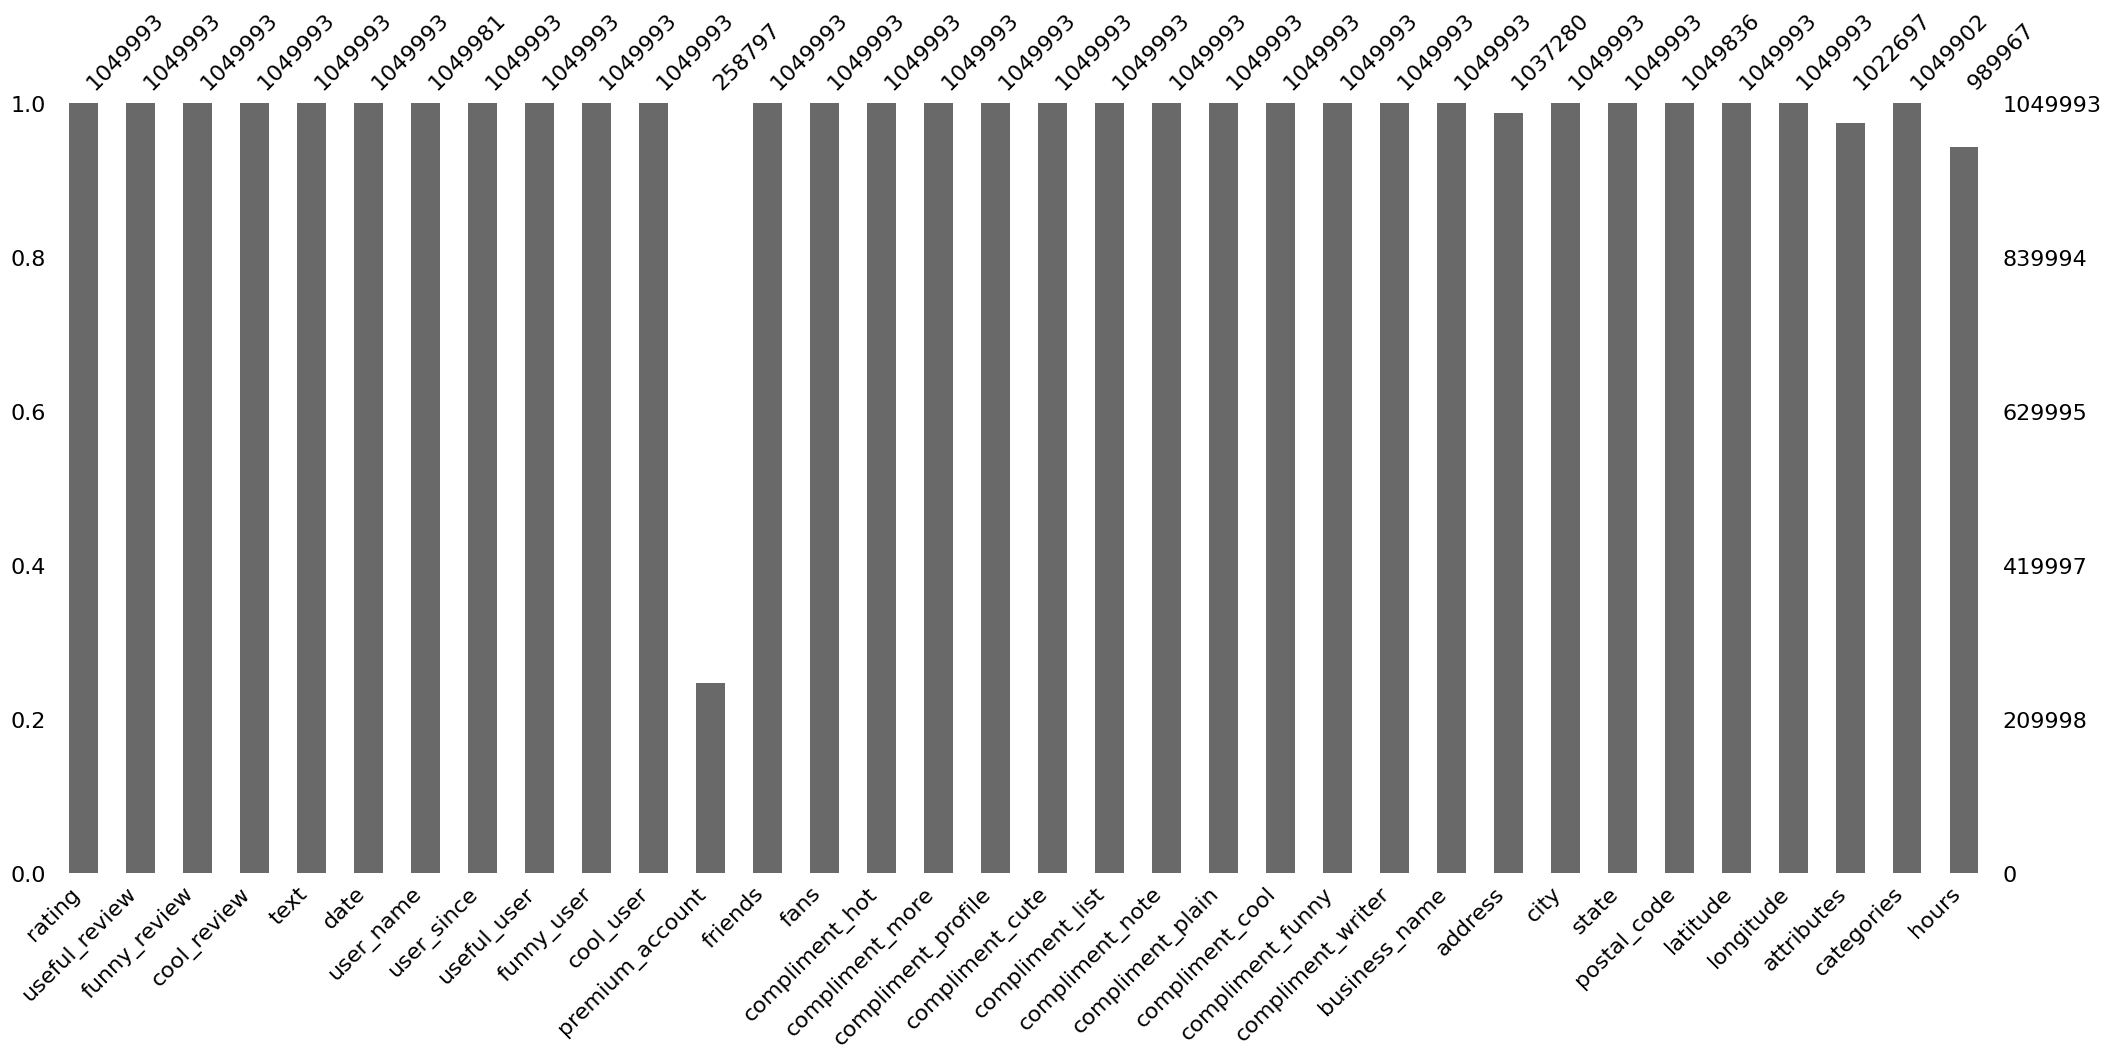

In [15]:
msno.bar(merged_reviews)

<Axes: >

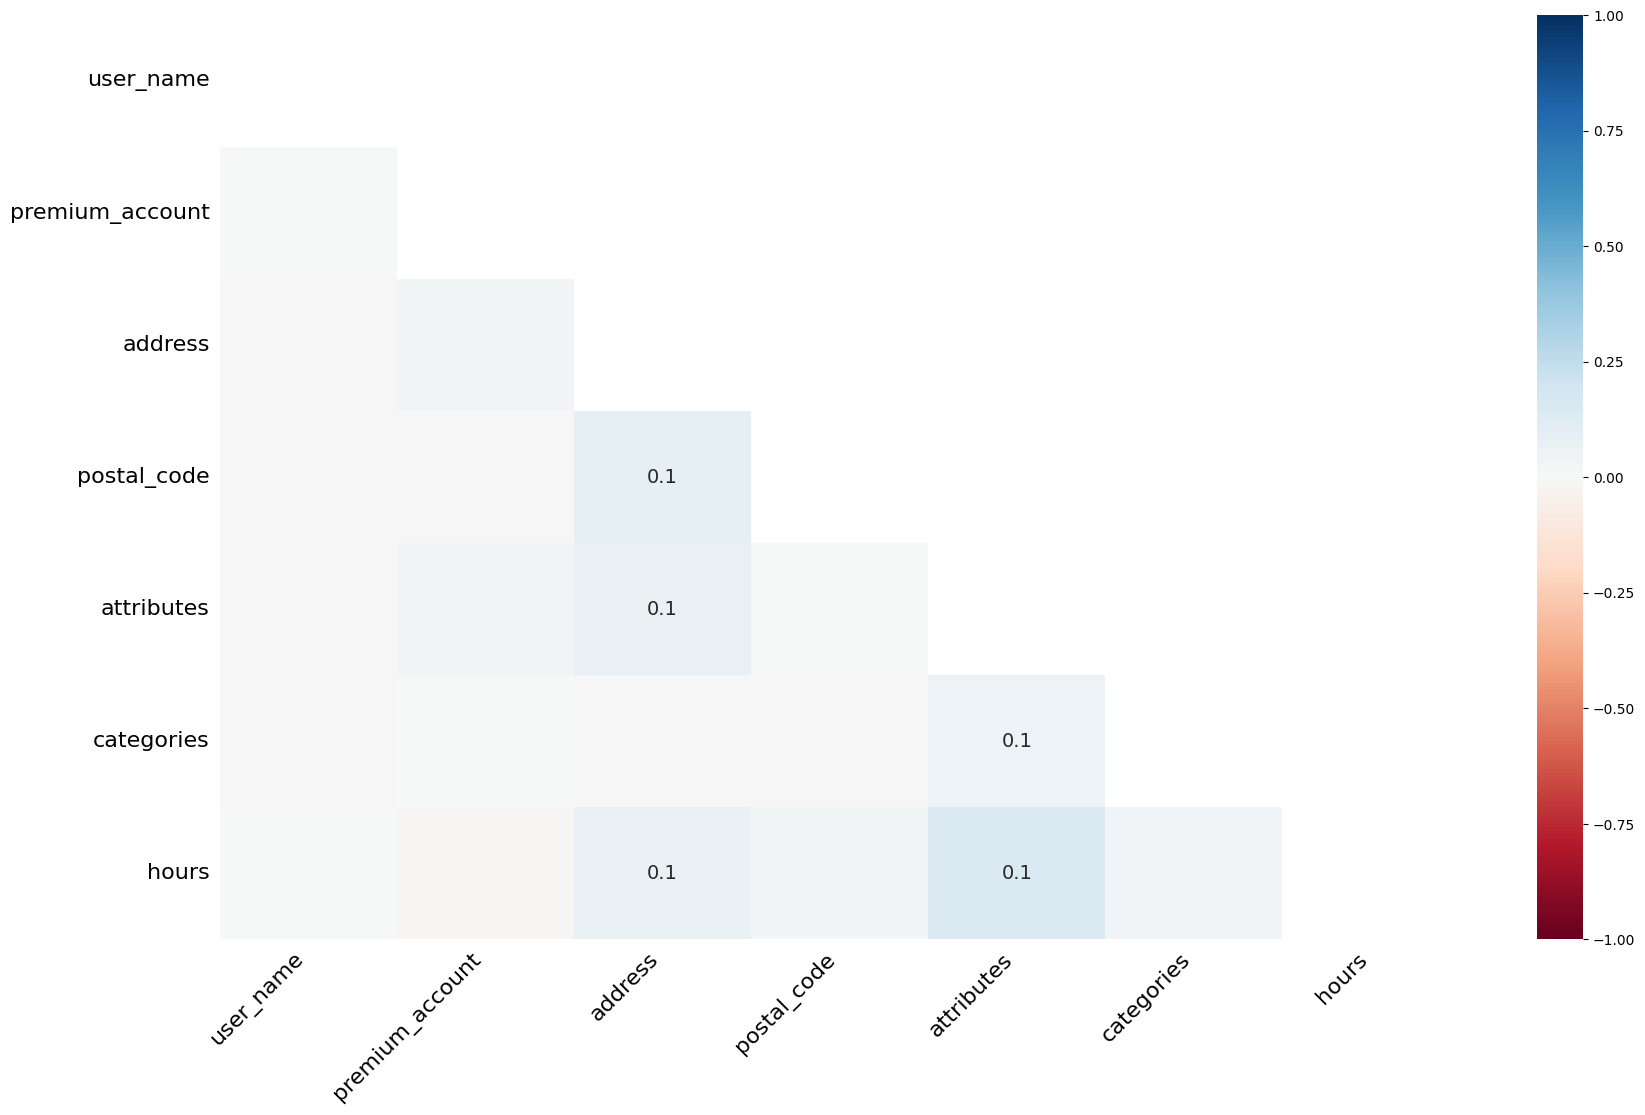

In [16]:
msno.heatmap(merged_reviews)

There is a vast majority of missing values for the variable premium_account, so we will discard it. There are uncorellated missing values for the variables user_name, address, postal_code, attributes, categories and hours. However, not that many are missing as we can see from the barplots. We will either remove these variables if we can consider them to be of low importance or simply drop observations with missing values if these variables hold value.

In [26]:
del df_users["premium_account"]

### Distribution

### Relationships

### Transform data

Ideas:

- Log when data is highly skewed.
- Binning of continuous variables.
- Simplifying of categories: Trying to aggregate to higher-level categories when it makes sense.


# Exploratory Data Analysis


## 1. Exploring individual variable


Quantify:

- _Location_:
  - mean
  - median
  - mode
  - interquartile mean
- _Spread_:
  - standard deviation
  - variance
  - range
  - interquartile range
- _Shape_:
  - skewness
  - kurtosis

For time series:
plot summary statistics over time.

For panel data:

- Plot cross-sectional summary statistics over time
- Plot time-series statistics across the population

#### Question

- What does each field in the data look like?
  - Is the distribution skewed? Bimodal?
  - Are there outliers? Are they feasible?
  - Are there discontinuities?
- Are the typical assumptions seen in modeling valid?
  - Gaussian
  - Identically and independently distributed
  - Have one mode
  - Can be negative
  - Generating processes are stationary and isoptropic (time series)
  - Independence between subjects (panel data)


## 2. Exploring the relationship between each variable and the target


How does each field interact with the target?

Assess each relationship’s:

- Linearity
- Direction
- Rough size
- Strength
  Methods:
- Bivariate visualizations
- Calculate correlation


## 3. Assessing interactions between variables


- Bivariate visualizations
- Correlation matrices
- Compare summary statistics of variable x for different categories of y


## 4. Exploring data across many dimensions


- Categorical:
  - Parallel coordinates
- Continuous
  - Principal component analysis
  - Clustering


# Feature Engineering


In [12]:
# Removal of informationlesss variables

# Basic preprocessing


Loss of observations: 7 obersevations


In [18]:
merged_reviews

,rating,useful_review,funny_review,cool_review,text,date,user_name,user_since,useful_user,funny_user,...,business_name,address,city,state,postal_code,latitude,longitude,attributes,categories,hours
0,5,1,0,0,"Sometimes you just want a cup of coffee, in a ...",2013-12-22 23:45:01,Adam,2013-12-22 23:42:29,2.0,1.0,...,Portland Brew,2605 12th Ave S,Nashville,TN,37204,36.123680,-86.790149,"{'WiFi': ""'free'"", 'OutdoorSeating': 'True', '...","Sandwiches, Coffee & Tea, Bagels, Food, Restau...","{'Monday': '7:0-17:0', 'Tuesday': '7:0-17:0', ..."
1,5,1,0,0,Mr. Clyde stopped at our house and asked us if...,2020-02-11 01:00:32,Christine,2019-10-15 13:14:25,5.0,0.0,...,Clyde & Son's Tree Service,5802 E 34th St,Tucson,AZ,85711,32.194106,-110.868540,None,"Home Services, Tree Services","{'Monday': '7:0-16:30', 'Tuesday': '7:0-16:30'..."
2,4,0,0,0,One of my favorite places to grab a quick bit ...,2014-05-28 19:05:26,Jacqueline,2013-11-27 01:55:41,146.0,54.0,...,Chickie's & Pete's,1526 Packer Ave,Philadelphia,PA,19145,39.911417,-75.174511,"{'GoodForKids': 'True', 'Corkage': 'False', 'H...","Seafood, Nightlife, Sports Bars, Bars, Restaur...","{'Monday': '11:0-2:0', 'Tuesday': '11:0-2:0', ..."
3,5,0,1,0,"Wow, this place is huge! Life size aquarium an...",2014-01-20 23:42:44,Dennis,2009-11-22 18:17:20,53.0,22.0,...,Scheels,1200 Scheels Dr,Sparks,NV,89434,39.531051,-119.721751,"{'RestaurantsPriceRange2': '2', 'BikeParking':...","Outdoor Gear, Fashion, Men's Clothing, Women's...","{'Monday': '9:0-18:0', 'Tuesday': '9:0-21:0', ..."
4,5,0,0,0,I ordered 3 large pizzas and wings for my fam...,2020-01-29 00:20:34,LeeAnn,2020-01-29 00:14:20,0.0,0.0,...,Pizza 54,16138 FL-54,Odessa,FL,33556,28.187041,-82.548173,"{'HasTV': 'True', 'RestaurantsTableService': '...","Restaurants, Pizza, Salad, Chicken Wings","{'Tuesday': '11:0-21:0', 'Wednesday': '11:0-21..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1049988,5,0,0,0,"QT is like the Bentley of gas stations, you're...",2018-05-04 06:55:33,April,2013-01-11 22:10:15,9.0,7.0,...,QuikTrip,12200 Dorsett Rd,Maryland Heights,MO,63043,38.713844,-90.443519,"{'BusinessParking': ""{'garage': False, 'street...","Convenience Stores, Automotive, Restaurants, F...","{'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'W..."
1049989,4,1,0,1,"The Salmon Dumplings, oh the Salmon Dumplings!...",2015-07-10 04:03:02,Huiwen,2015-05-15 03:01:12,15.0,1.0,...,Seiko Japanese Restaurant,604 N 2nd St,Philadelphia,PA,19123,39.961212,-75.141571,"{'RestaurantsTableService': 'True', 'WiFi': ""u...","Restaurants, Japanese, Watches, Sushi Bars, Sh...","{'Monday': '17:0-22:0', 'Tuesday': '17:0-22:0'..."
1049990,5,3,0,1,"So for those who don't know my reviews, I post...",2019-11-10 20:45:30,Nikki,2018-11-08 01:02:28,5.0,3.0,...,a.bar,1737 Walnut St,Philadelphia,PA,19103,39.950271,-75.170514,"{'NoiseLevel': ""u'average'"", 'RestaurantsAttir...","Bars, Tapas Bars, Restaurants, American (Tradi...","{'Monday': '17:0-22:0', 'Tuesday': '17:0-22:0'..."
1049991,4,0,0,0,Fratelli's is a great local Italian spot. When...,2016-10-30 17:36:49,Sumiko,2015-02-24 18:56:50,25.0,1.0,...,Fratelli's Italian Restaurant,1414 Rt 130 N,Burlington,NJ,08016,40.087250,-74.827738,"{'HasTV': 'True', 'RestaurantsGoodForGroups': ...","Italian, Restaurants, Pizza","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'..."


# Models


# Models Comparison & Best Model Assessment
